-----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Librerias

In [38]:
import pandas as pd
import json
from collections import defaultdict
import re
import numpy as np
from utils.utilities import Tiempo
import utils.dataExtraction
import statistics
import keyword
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import xml.etree.ElementTree as ET

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que extrae los timestamps de inicio y fin de cada intentos de nivel
#### También extrae las estrellas obtenidas en cada intentos y cuantas veces se han intentado todos los niveles por cada jugador 

In [2]:
def extraerTiemposPorNivelJugador(rawData):
    
    tiempos = defaultdict(defaultdict)
    intentosNecesarios = defaultdict(defaultdict)
    
    erLevel = re.compile(r'\blevel$\b')
    erIdLevel = re.compile(r'/')
    
    erInitialized = re.compile(r'\binitialized$\b')
    erCompleted = re.compile(r'\bcompleted$\b')
    
    for evento in rawData:
        verb = evento["verb"]["id"]
        obj = evento["object"]["definition"]["type"]
        name = evento["actor"]["name"]
        timestamp = evento["timestamp"]
        objectId = evento["object"]["id"]
        
        if erLevel.search(obj): #Si el objeto de la acción es un nivel
            levelCode = erIdLevel.split(objectId)[-1]
            if levelCode != "editor_level":
                if erInitialized.search(verb): #Si la acción es inicio o reinicio
                    if "result" in evento: #Significa que ha iniciado el nivel desde el menu
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode].append({"intentos" : 1, "success" : False})
                            tiempos[name][levelCode].append({"ini" : timestamp, "fin" : None, "stars" : ""})
                        else:
                            intentosNecesarios[name][levelCode] = [{"intentos" : 1, "success" : False}]
                            tiempos[name][levelCode] = [{"ini" : timestamp, "fin" : None, "stars" : ""}]
                    else:
                        intentosNecesarios[name][levelCode][-1]["intentos"] += 1
                elif erCompleted.search(verb):
                    if evento["result"]["score"]["raw"] > 0 :
                        if levelCode in tiempos[name]:
                            intentosNecesarios[name][levelCode][-1]["success"] = True
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]

                    elif evento["result"]["score"]["raw"] == -1:
                        if levelCode in tiempos[name]:
                            tiempos[name][levelCode][-1]["fin"] = timestamp
                            tiempos[name][levelCode][-1]["stars"] = evento["result"]["score"]["raw"]
    
    return {"tiempos" : tiempos, "intentosNecesarios" : intentosNecesarios}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que resta los timestamps de inicio y fin de cada intento de nivel para sacar la diferencia de tiempo

In [3]:
def tiempoPorNiveles_Jugador(data):
    tiemposJugados = defaultdict(defaultdict)
    for player in data:
        for level in data[player]:
            for times in data[player][level]:
                if times["fin"] != None: #Si no se aborto el intento del nivel
                    timeDifference = Tiempo(times["ini"], times["fin"])
                    if level in tiemposJugados[player]:
                        tiemposJugados[player][level].append({"time" : timeDifference, "stars" : times["stars"]})
                    else:
                        tiemposJugados[player][level] = [{"time" : timeDifference, "stars" : times["stars"]}]
    return tiemposJugados

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que devuelve el tiempo medio necesario para completar un nivel y un diccionario con el tiempo empleado por cada jugador hasta completar el nivel
(El tiempo necesario para cada jugador es la suma de todos los tiempos hasta conseguir completar el nivel)
* También devuelve la media de estrellas y una lista de los niveles ordenados

In [4]:
#TAMBIEN DEVUELVE EL TIEMPO INDIVIDUAL DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getMediaTiempoPorNivel(tiempos, soloPrimerExito = True, tiemposOrdenados = False):
    medias = defaultdict(list)
    mediasEstrellas = defaultdict(list)
    tiempoCompletarNivelIndividual = defaultdict(defaultdict)
    
    for player in tiempos:
        for level in tiempos[player]:
            tAux = Tiempo("0s")
            for t in tiempos[player][level]:
                if t["stars"] != -1:
                    if level in medias:
                        medias[level].append(int(tAux + t["time"]))
                        mediasEstrellas[level].append(int(t["stars"]))
                    else:
                        medias[level] = [int(tAux + t["time"])]
                        mediasEstrellas[level] = [int(t["stars"])]
                        
                    tiempoCompletarNivelIndividual[player][level] = tAux + t["time"]
                    if soloPrimerExito:
                        break
                elif t["stars"] == 0:
                    print("ALERTA")
                else:
                    tAux += t["time"]
    for m in medias:
        medias[m] = Tiempo(str(int(round(statistics.mean(medias[m]), 0))) + "s")
        
    for m in mediasEstrellas:
        mediasEstrellas[m] = statistics.mean(mediasEstrellas[m])
    
    listaNiveles = medias.keys()
    
    if tiemposOrdenados:
        medias = sorted(medias.items(), key=lambda x: x[1])
        mediasEstrellas = sorted(mediasEstrellas.items(), key=lambda x: x[1])
    else:
        medias = list(medias.items())
        mediasEstrellas = list(mediasEstrellas.items())
    
    return {"mediaTiempos" : medias, "mediaEstrellas" : mediasEstrellas, "listaNiveles" : listaNiveles, "tiemposIndividuales" : tiempoCompletarNivelIndividual}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve un diccionario con clave: id Jugador y valor: ultimo nivel alcanzado

In [5]:
def getUltimoNivelAlcanzado(tiempos):
    ultNivel = defaultdict()
    for player in tiempos:
        for level in tiempos[player]:
            ultNivel[player] = level
    return ultNivel

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Devuelve los intentos necesarios de cada jugador para completar un nivel al igual que los intentos medios

In [6]:
#TAMBIEN DEVUELVE LOS INTENTOS INDIVIDUALES DE CADA JUGADOR PARA COMPLETAR CADA NIVEL
def getIntentosMedios_HastaCompletarNivel(intentosNecesarios, intentosOrdenados = False):
    intentosMedios = defaultdict(list)
    intentosCompletarNivelIndividual = defaultdict(defaultdict)
    
    for name in intentosNecesarios:
        for level in intentosNecesarios[name]:
            cont = 0
            for i in intentosNecesarios[name][level]:
                cont += i["intentos"]
                if i["success"] == True:
                    intentosMedios[level].append(cont)
                    intentosCompletarNivelIndividual[name][level] = cont
                    break
            
    for level in intentosMedios:
        intentosMedios[level] = round(statistics.mean(intentosMedios[level]), 2)
    
    if intentosOrdenados:
        intentosMedios = sorted(intentosMedios.items(), key=lambda x: x[1])
    else:
        intentosMedios = list(intentosMedios.items())
    return {"intentosMedios" : intentosMedios, "intentosIndividual" : intentosCompletarNivelIndividual}

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Transforma un diccionario de diccionarios en un diccionario de arrays
* Se utiliza para tener una lista de todos los tiempos de los usuarios cuando tenemos un diccionario dentro de otro con primera clave nombre usuario y segunda clave codigo del nivel

In [7]:
def extraerArray(my_dict):
    nested_keys = []
    nested_values = []

    for k, v in my_dict.items():
        for nested_k, nested_v in v.items():
            nested_keys.append(nested_k)
            nested_values.append(nested_v)

    # create a dictionary with keys as the values of the nested_keys array
    nested_dict = defaultdict(list)
    for key, value in zip(nested_keys, nested_values):
        nested_dict[key].append(value)
    
    return nested_dict

In [8]:
def extraerArrayConNombres(my_dict):
    nested_keys = []
    nested_values = []

    for k, v in my_dict.items():
        for nested_k, nested_v in v.items():
            nested_keys.append(nested_k)
            nested_values.append({"name" : k, "valor" : nested_v})

    # create a dictionary with keys as the values of the nested_keys array
    nested_dict = defaultdict(defaultdict)
    for key, value in zip(nested_keys, nested_values):
        nested_dict[key][value["name"]] = value["valor"]
    
    return nested_dict

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Recibe un diccionario con clave nivel y valor una lista de tiempos y parsea los tiempos a integer

In [9]:
def parseTiemposDictToInteger(data_dict):
    parsed_dict = {}

    for key, value in data_dict.items():
        parsed_list = []
        for element in value:
            parsed_list.append(int(element))
        parsed_dict[key] = parsed_list

    return parsed_dict

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
### Función que genera los boxplots recibiendo un diccionario con clave nivel y valor una lista de enteros

In [10]:
def create_boxplots(data_dict):
    # Group levels by category
    category_dict = {}
    for level, data in data_dict.items():
        category = level.split('_')[0]
        if category in category_dict:
            category_dict[category].append(data)
        else:
            category_dict[category] = [data]
    
    # Create boxplots for each category and add relevant information
    boxplots = []
    labels = []
    for i, (category, data_list) in enumerate(category_dict.items()):
        fig, ax = plt.subplots()
        bp = ax.boxplot(data_list, showfliers=True, patch_artist=True, flierprops={'marker': '+', 'markerfacecolor': '#738FA7'})
        ax.set_title(category)

        color = '#738FA7'
        for patch in bp['boxes']:
            patch.set_facecolor(color)
        
        boxplots.append(bp)
        labels.append(category)
    
    # Set tick labels
    fig, ax = plt.subplots()
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelrotation=45)
    
    return boxplots


In [11]:
def getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles):
    cuantosHanLlegadoAlNivel = defaultdict()
    
    ultNivelCopia = ultNivelCompletado.copy()

    #Contamos cuanta gente ha llegado hasta cada nivel
    for nivel in niveles:
        cuantosHanLlegadoAlNivel[nivel] = len(ultNivelCopia)
        
        keys_to_delete = [k for k, v in ultNivelCopia.items() if v == nivel]
        for k in keys_to_delete:
            del ultNivelCopia[k]

    return cuantosHanLlegadoAlNivel

In [12]:
def generateChartNivelesAlcanzados(niveles, ultNivelCompletado):
    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)

    category_dict = {}
    for level, value in cuantosHanLlegadoAlNivel.items():
        category = level.split('_')[0]
        level_number = int(level.split('_')[-1])
        if category in category_dict:
            category_dict[category].append((level_number, value))
        else:
            category_dict[category] = [(level_number, value)]
    for category, levels in category_dict.items():
        category_dict[category] = sorted(levels, key=lambda x: x[0])

    # Select the last level for each category
    last_levels = {}
    for category, levels in category_dict.items():
        last_level = levels[-1][0]
        last_levels[category] = levels[-1][1]

    # Create bar chart and add labels
    fig, ax = plt.subplots()
    ax.bar(last_levels.keys(), last_levels.values(), color="#738FA7")
    ax.set_xticklabels(last_levels.keys(), rotation=45, ha='right')
        
    plt.show()

In [13]:
def generateChartNivelesAlcanzados2(niveles, ultNivelCompletado):
    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)
    ultNivelCat = {}
    for level in cuantosHanLlegadoAlNivel:
        ultNivelCat[(" ".join(level.split("_")[:-1])).capitalize()] = cuantosHanLlegadoAlNivel[level]
    
    df = pd.DataFrame({"levels" : list(ultNivelCat.keys()), "nJugadores" : list(ultNivelCat.values())})
    fig = px.bar(df, x="levels", y='nJugadores', labels={'levels':'Categorías', 'nJugadores':'Numero Jugadores'})
    fig.update_traces(marker_color='#738FA7')
    fig.update_layout(plot_bgcolor='#C3CEDA')
    fig.write_json("./plots/categorias.json")
    return fig


In [14]:
def getChartPorcentajeCategorias(niveles, ultNivelCompletado, total_players):

    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)

    ultimoNivelCat = {}
    for level in niveles:
        category = level.split("_")[0]
        ultimoNivelCat[category] = level
    
    percentages = {}
    for ultNivel in ultimoNivelCat.values():
        percentages[ultNivel] = (cuantosHanLlegadoAlNivel[ultNivel]/total_players)*100
    
    fig, ax = plt.subplots()
    ax.bar(range(len(percentages)), list(percentages.values()), align='center', color="#738FA7")
    ax.set_xticks(range(len(percentages)))
    ax.set_xticklabels(map(lambda c: c.split("_")[0], list(percentages.keys())), rotation=45, ha='right')
    ax.set_ylim((0, 100))
    ax.set_ylabel('Porcentaje Jugadores')
    ax.set_xlabel('Categorías')
    ax.set_title('Categorías Superadas')
    
    return ax

In [15]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = None

In [16]:
JSONFile = open('./data/trazasOrdenadas.json')
rawData = json.load(JSONFile)
JSONFile.close()

resultados_Tiempos_Nivel_Jugador = extraerTiemposPorNivelJugador(rawData)

In [17]:
tiemposIntentosJugadores = tiempoPorNiveles_Jugador(resultados_Tiempos_Nivel_Jugador["tiempos"])
#pd.DataFrame(tiemposIntentosJugadores)
#pd.DataFrame(resultados_Tiempos_Nivel_Jugador["intentosNecesarios"])

In [18]:
soloPrimerExito = True
tiemposOrdenados = False
tiemposMedios = getMediaTiempoPorNivel(tiemposIntentosJugadores, soloPrimerExito, tiemposOrdenados)
#pd.DataFrame(tiemposMedios["mediaTiempos"])
#pd.DataFrame(tiemposMedios["mediaEstrellas"])
#pd.DataFrame(tiemposMedios["listaNiveles"])
#pd.DataFrame(tiemposMedios["tiemposIndividuales"])

In [19]:
ultNivelAlcanzado = getUltimoNivelAlcanzado(tiemposMedios["tiemposIndividuales"])
#print(ultNivelAlcanzado)

In [20]:
intentosOrdenados = False
intentosMedios_Individual = getIntentosMedios_HastaCompletarNivel(resultados_Tiempos_Nivel_Jugador["intentosNecesarios"], intentosOrdenados)
#pd.DataFrame(intentosMedios_Individual["intentosMedios"])
#pd.DataFrame(intentosMedios_Individual["intentosIndividual"])

In [21]:
tiemposList = extraerArray(tiemposMedios["tiemposIndividuales"])
intentosList = extraerArray(intentosMedios_Individual["intentosIndividual"])
#pd.DataFrame.from_dict(tiemposList, orient='index').transpose()
#pd.DataFrame.from_dict(intentosList, orient='index').transpose()

In [22]:
intentosListNombres = extraerArrayConNombres(intentosMedios_Individual["intentosIndividual"])
tiemposListNombres = extraerArrayConNombres(tiemposMedios["tiemposIndividuales"])
#pd.DataFrame.from_dict(intentosListNombres, orient='index').transpose()
#pd.DataFrame.from_dict(tiemposListNombres, orient='index').transpose()

In [23]:
def parseTiemposDictConNombresToInteger(tiemposDict):
    for l in tiemposDict:
        for j in tiemposDict[l]:
            tiemposDict[l][j] = int(tiemposDict[l][j])
    return tiemposDict

In [24]:
fig = generateChartNivelesAlcanzados2(tiemposMedios["listaNiveles"], ultNivelAlcanzado)
fig.show()

<AxesSubplot: title={'center': 'Categorías Superadas'}, xlabel='Categorías', ylabel='Porcentaje Jugadores'>

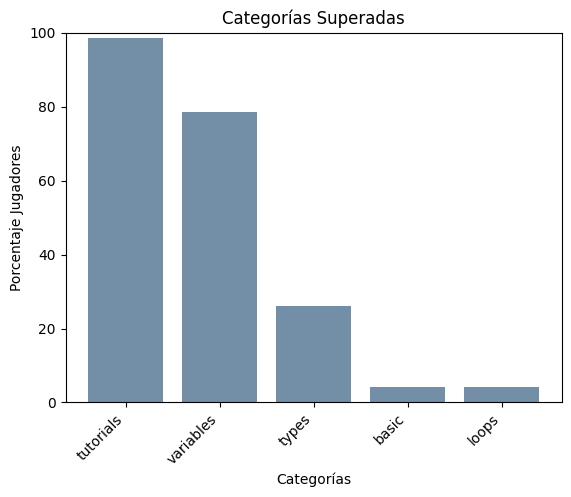

In [25]:
getChartPorcentajeCategorias(tiemposMedios["listaNiveles"], ultNivelAlcanzado, len(ultNivelAlcanzado))

In [26]:
#boxplotsIntentos = create_boxplots(intentosList)

In [27]:
#boxplotsTiempos = create_boxplots(parseTiemposDictToInteger(tiemposList))

In [34]:
def create_boxplots3(data_dict, titulo):
    categorias = defaultdict(defaultdict)
    for d in data_dict:
        categorias[d.split("_")[0]][d] = data_dict[d]

    boxplots = []
    for c in categorias:
        df = pd.DataFrame.from_dict(categorias[c], orient="index")
        df = df.reset_index()
        df = df.rename(columns={'index' : 'Niveles'})
        df_melted = df.melt(id_vars=['Niveles'], var_name='Jugador', value_name=titulo)

        # create boxplot
        fig = px.box(df_melted, x='Niveles', y=titulo, hover_name='Jugador')
        #fig.write_json("./plots/"+c + "_"+ titulo +".json")
        #fig.update_layout(median=dict(name='Mediana'), lowerfence=dict(name='Límite inferior'), upperfence=dict(name='Límite superior'))
        fig.update_traces(marker_color='#738FA7')
        fig.update_layout(plot_bgcolor='#C3CEDA')
        boxplots.append(fig)
    return boxplots

In [29]:
boxsIntentos= create_boxplots3(intentosListNombres, 'Intentos')
for b in boxsIntentos:
    #b.show()
    None

In [36]:
boxsTiempos = create_boxplots3(parseTiemposDictConNombresToInteger(tiemposListNombres), "Tiempo(s)")
for b in boxsTiempos:
    #b.show()
    None

In [57]:
def getChartPorcentajeCategorias2(niveles, ultNivelCompletado, total_players):
    cuantosHanLlegadoAlNivel = getCuantasPersonasHanAlcanzadoNivel(ultNivelCompletado, niveles)
    ultNivelCat = {}
    for level in cuantosHanLlegadoAlNivel:
        ultNivelCat[(" ".join(level.split("_")[:-1])).capitalize()] = cuantosHanLlegadoAlNivel[level]

    for c in ultNivelCat:
        ultNivelCat[c] = round((ultNivelCat[c]/total_players)*100, 2)

    fig = go.Figure(data=[
        go.Bar(name="Clase", x=list(ultNivelCat.keys()), y=list(ultNivelCat.values())),
        go.Bar(name="Global", x=list(ultNivelCat.keys()), y=list(ultNivelCat.values())),
    ])

    fig.update_layout(barmode='group')
    fig.show()

In [58]:
getChartPorcentajeCategorias2(tiemposMedios["listaNiveles"], ultNivelAlcanzado, len(ultNivelAlcanzado))


ValueError: Invalid property specified for object of type plotly.graph_objs.Bar: 'color'

Did you mean "base"?

    Valid properties:
        alignmentgroup
            Set several traces linked to the same position axis or
            matching axes to the same alignmentgroup. This controls
            whether bars compute their positional range dependently
            or independently.
        base
            Sets where the bar base is drawn (in position axis
            units). In "stack" or "relative" barmode, traces that
            set "base" will be excluded and drawn in "overlay" mode
            instead.
        basesrc
            Sets the source reference on Chart Studio Cloud for
            `base`.
        cliponaxis
            Determines whether the text nodes are clipped about the
            subplot axes. To show the text nodes above axis lines
            and tick labels, make sure to set `xaxis.layer` and
            `yaxis.layer` to *below traces*.
        constraintext
            Constrain the size of text inside or outside a bar to
            be no larger than the bar itself.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.bar.ErrorX` instance or
            dict with compatible properties
        error_y
            :class:`plotly.graph_objects.bar.ErrorY` instance or
            dict with compatible properties
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.bar.Hoverlabel` instance
            or dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variables `value` and `label`. Anything
            contained in tag `<extra>` is displayed in the
            secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        insidetextanchor
            Determines if texts are kept at center or start/end
            points in `textposition` "inside" mode.
        insidetextfont
            Sets the font used for `text` lying inside the bar.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.bar.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        legendwidth
            Sets the width (in px or fraction) of the legend for
            this trace.
        marker
            :class:`plotly.graph_objects.bar.Marker` instance or
            dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        offset
            Shifts the position where the bar is drawn (in position
            axis units). In "group" barmode, traces that set
            "offset" will be excluded and drawn in "overlay" mode
            instead.
        offsetgroup
            Set several traces linked to the same position axis or
            matching axes to the same offsetgroup where bars of the
            same position coordinate will line up.
        offsetsrc
            Sets the source reference on Chart Studio Cloud for
            `offset`.
        opacity
            Sets the opacity of the trace.
        orientation
            Sets the orientation of the bars. With "v" ("h"), the
            value of the each bar spans along the vertical
            (horizontal).
        outsidetextfont
            Sets the font used for `text` lying outside the bar.
        selected
            :class:`plotly.graph_objects.bar.Selected` instance or
            dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stream
            :class:`plotly.graph_objects.bar.Stream` instance or
            dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textangle
            Sets the angle of the tick labels with respect to the
            bar. For example, a `tickangle` of -90 draws the tick
            labels vertically. With "auto" the texts may
            automatically be rotated to fit with the maximum size
            in bars.
        textfont
            Sets the font used for `text`.
        textposition
            Specifies the location of the `text`. "inside"
            positions `text` inside, next to the bar end (rotated
            and scaled if needed). "outside" positions `text`
            outside, next to the bar end (scaled if needed), unless
            there is another bar stacked on this one, then the text
            gets pushed inside. "auto" tries to position `text`
            inside the bar, but if the bar is too small and no bar
            is stacked on this one the text is moved outside. If
            "none", no text appears.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            `textposition`.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variables `value` and `label`.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.bar.Unselected` instance
            or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        width
            Sets the bar width (in position axis units).
        widthsrc
            Sets the source reference on Chart Studio Cloud for
            `width`.
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        
Did you mean "base"?

Bad property path:
color
^^^^^